In [1]:
import sys
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install mrcfile
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install Pillow
# !{sys.executable} -m pip install POT
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install numba
# !{sys.executable} -m pip install Bio
# !{sys.executable} -m pip install tornado==4.5.3
!pip freeze

absl-py==1.0.0
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1670263926556/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1687772187254/work
beautifulsoup4==4.12.2
biopython==1.81
boltons @ file:///work/ci_py311/boltons_1677685195580/work
boto3==1.28.25
botocore==1.31.25
Bottleneck @ file:///work/ci_py311/bottleneck_1676827011612/work
brotlipy==0.7.0
bs4==0.0.1
certifi==2023.7.22
cffi @ file:///work/ci_py311/cffi_1676822533496/work
charset-normalizer @ file:///tmp/build/80754af9/charset-normalizer_1630003229654/work
cmake==3.27.2
comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1691044910542/work
conda @ file:///home/conda/feedstock_root/build_artifacts/conda_1692727129499/work
conda-content-trust @ file:///work/ci_py311/conda-content-trust_1676851327497/work
conda-libmamba-solver @ file:///

In [3]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import math
import numpy as np
import ot
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import seaborn as sns
import json

import mrcfile
import pandas as pd
import trn, coords, gauss_forward_model
import importlib
importlib.reload(trn)

import torch
from unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn
from unbalancedgw.vanilla_ugw_solver import log_ugw_sinkhorn
from unbalancedgw._vanilla_utils import ugw_cost
from unbalancedgw.utils import generate_measure
from unbalancedgw._vanilla_utils import l2_distortion

from scipy.spatial.transform import Rotation

from Bio import PDB
from Bio.PDB.vectors import Vector, rotmat

plt.rcParams["figure.figsize"] = (20,20)

In [4]:
class Term:
    def __init__(self, coef=1, exps=[0,0,0,0]):
        self.coef = coef
        self.exps = exps
        while len(self.exps) < 8:
            self.exps.append(0)
    
    def derivative(self, index):
        new_exps = [0,0,0,0,0,0,0,0]
        for i in range(8):
            if i != index:
                new_exps[i] = self.exps[i]
            else:
                new_exps[i] = self.exps[i] - 1
        return Term(coef=self.coef*self.exps[index], exps=new_exps)
    
    def evaluate(self, vals):
        s = self.coef
        if s == 0:
            return 0
        for i in range(min(len(vals), len(self.exps))):
            if self.exps[i] == 0:
                continue
            elif self.exps[i] == 1:
                s *= vals[i]
            elif self.exps[i] == 2:
                s *= vals[i] * vals[i]
            elif self.exps[i] == 3:
                s *= vals[i] * vals[i] * vals[i]
            else:
                print(self.exps[i])
                s *= vals[i] ** self.exps[i]
        return s
    
    def bunch_evaluate(self, bunch_vals):
        s = self.coef
        for i in range(min(len(bunch_vals), len(self.exps))):
            for j in range(self.exps[i]):
                s = np.multiply(s, bunch_vals[i])
        return s
    
    def __mul__(self, other):
        coef = self.coef * other.coef
        exps = []
        for i in range(8):
            exps.append(self.exps[i] + other.exps[i])
        return Term(coef=coef, exps=exps)
    
    def __neg__(self):
        return Term(coef=-self.coef, exps=self.exps)
    
    def __str__(self):
        s = ""
        for i in range(8):
            if self.exps[i] != 0:
                s += "q" + str(i) + "^" + str(self.exps[i])
        return str(self.coef) + "*" + s
    
    def is_similar(self, other):
        for i in range(8):
            if self.exps[i] != other.exps[i]:
                return False
        return True
    
    def simplify(self, vals):
        new_exps = [0,0,0,0,0,0,0,0]
        coef = self.coef
        for i in range(8):
            if vals[i] != 'x':
                coef *= vals[i]**self.exps[i]
            else:
                new_exps[i] = self.exps[i]
        return Term(coef=self.coef*self.exps[index], exps=new_exps)
        
    
class Polynomial:
    def __init__(self, terms=None):
        if terms is None:
            terms = []
        self.terms = {}
        for term in terms:
            self.terms[tuple(term.exps)] = term
        
    def add_term(self, term):
        if term.coef == 0:
            return
        if tuple(term.exps) not in self.terms:
            self.terms[tuple(term.exps)] = term
        else:
            self.terms[tuple(term.exps)].coef += term.coef

    def get_terms(self):
        terms = []
        for exps in self.terms:
            terms.append(self.terms[exps])
        return terms
        
    def derivative(self, index):
        res = Polynomial()
        for term in self.get_terms():
            res.add_term(term.derivative(index))
        return res
    
    def simplify(self, vals):
        res = ()
        for term in self.get_terms():
            res.add_term(term.simplify(vals))
        return res
    
    def evaluate(self, vals):
        t = 0
        for term in self.get_terms():
            t += term.evaluate(vals)
        return t
    
    def bunch_evaluate(self, bunch_vals):
        t = 0
        for term in self.get_terms():
            t = np.add(t, term.bunch_evaluate(bunch_vals))
        return t
    
    def __add__(self, other):
        res = Polynomial()
        for term in self.get_terms():
            res.add_term(term)
        for term in other.get_terms():
            res.add_term(term)
        return res
    
    def __sub__(self, other):
        res = Polynomial()
        for term in self.get_terms():
            res.add_term(term)
        for term in other.get_terms():
            res.add_term(-term)
        return res
    
    def __neg__(self):
        res = Polynomial()
        for term in self.get_terms():
            res.add_term(-term)
        return res
    
    def __mul__(self, other):
        res = Polynomial()
        for term1 in self.get_terms():
            for term2 in other.get_terms():
                res.add_term(term1*term2)
        return res
    
    def __str__(self):
        s = ""
        terms = self.get_terms()
        for i in range(len(terms)):
            if i > 0:
                s += " + "
            s += str(terms[i])
        return s

class Quaternion:
    def __init__(self, real_pol, i_pol, j_pol, k_pol):
        self.real_pol = real_pol
        self.i_pol = i_pol
        self.j_pol = j_pol
        self.k_pol = k_pol
        
    def conjugate(self):
        return Quaternion(self.real_pol, -self.i_pol, -self.j_pol, -self.k_pol)
    
    def __mul__(self, other):
        return Quaternion(self.real_pol*other.real_pol - self.i_pol*other.i_pol - self.j_pol*other.j_pol - self.k_pol*other.k_pol,
                          self.real_pol*other.i_pol + self.i_pol*other.real_pol + self.j_pol*other.k_pol - self.k_pol*other.j_pol,
                          self.real_pol*other.j_pol + self.j_pol*other.real_pol + self.k_pol*other.i_pol - self.i_pol*other.k_pol,
                          self.real_pol*other.k_pol + self.k_pol*other.real_pol + self.i_pol*other.j_pol - self.j_pol*other.i_pol)
    
    def __str__(self):
        return str(self.real_pol) + " + (" + str(self.i_pol) + ")i + (" + str(self.j_pol) + ")j + (" + str(self.k_pol) + ")k"
    

In [5]:
q = Quaternion(Polynomial([Term(coef=1, exps=[1,0,0,0])]), Polynomial([Term(coef=1, exps=[0,1,0,0])]), 
               Polynomial([Term(coef=1, exps=[0,0,1,0])]), Polynomial([Term(coef=1, exps=[0,0,0,1])]))
qs = q.conjugate()
print('The conjugate of %s is %s.'%(str(q), str(qs)))
print('The multiplication of %s and %s is equal to %s.'%(str(q), str(qs), str(q*qs)))

The conjugate of 1*q0^1 + (1*q1^1)i + (1*q2^1)j + (1*q3^1)k is 1*q0^1 + (-1*q1^1)i + (-1*q2^1)j + (-1*q3^1)k.
The multiplication of 1*q0^1 + (1*q1^1)i + (1*q2^1)j + (1*q3^1)k and 1*q0^1 + (-1*q1^1)i + (-1*q2^1)j + (-1*q3^1)k is equal to 1*q0^2 + 1*q1^2 + 1*q2^2 + 1*q3^2 + (0*q2^1q3^1)i + (0*q1^1q3^1)j + (0*q1^1q2^1)k.


In [6]:
def get_quaternion_vals(theta, ax, ay, az):
    """
    Compute the quaternion representation for a given rotation in angle-axis representation
    params:
        theta: the angle of the rotation in radians
        ax, ay, az: three floats in a way that *ax, ay, az) shows the 3d axis of the rotation

    retrun:
        q: is a list of length 4 that has values of the corresponding quaternion
    """
    
    n = math.sqrt(ax**2 + ay**2 + az**2)
    return [math.cos(theta/2), math.sin(theta/2)*ax/n, math.sin(theta/2)*ay/n, math.sin(theta/2)*az/n]

def convert_to_poly(vals):
    return Quaternion(Polynomial([Term(coef=vals[0], exps=[0,0,0,0])]), Polynomial([Term(coef=vals[1], exps=[0,0,0,0])]), 
                      Polynomial([Term(coef=vals[2], exps=[0,0,0,0])]), Polynomial([Term(coef=vals[3], exps=[0,0,0,0])]))
    

def perform(x, y, z, vals):
    """
    Apply a given rotation on a given point cloud and generate a new point cloud
    params:
        x, y, z: three lists with len(x)=len(y)=len(z) in a way that (x[i], y[i], z[i]) is the 3d coordinates of the i-th point
        vals: a list of length 4 that contains the values of the quaternion correponding the the ritation

    return:
        xr, yr, zr: three lists with len(xr)=len(yr)=len(zr) in a way that (xr[i], yr[i], zr[i]) is the 3d coordinates of the i-th point after the rotation
    """
    
    xr = []
    yr = []
    zr = []
    q = convert_to_poly(vals)
    qs = q.conjugate()
    p = Quaternion(Polynomial([Term(coef=1, exps=[1,0,0,0])]), Polynomial([Term(coef=1, exps=[0,1,0,0])]), 
                   Polynomial([Term(coef=1, exps=[0,0,1,0])]), Polynomial([Term(coef=1, exps=[0,0,0,1])]))
    t = time.time()
    b = q*p*qs
    t = time.time()
    
    bunch_vals = [np.zeros(len(x)), np.array(x), np.array(y), np.array(z)]
    xr = list(b.i_pol.bunch_evaluate(bunch_vals))
    yr = list(b.j_pol.bunch_evaluate(bunch_vals))
    zr = list(b.k_pol.bunch_evaluate(bunch_vals))
    
    return xr, yr, zr


In [7]:
def my_sinkhorn(a, b, M, reg, numItermax=5000, stopThr=1e-3, prev=None):

    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    M = np.asarray(M, dtype=np.float64)

    # init data
    dim_a = len(a)
    dim_b = len(b)
    
    if prev is None:
        u = np.ones(dim_a) / dim_a
        v = np.ones(dim_b) / dim_b
    else:
        u = prev[0]
        v = prev[1]
    
    # Next 3 lines equivalent to K= np.exp(-M/reg), but faster to compute
    K = np.empty(M.shape, dtype=M.dtype)
    np.divide(M, -reg, out=K)
    np.exp(K, out=K)

    tmp2 = np.empty(b.shape, dtype=M.dtype)

    Kp = (1 / a).reshape(-1, 1) * K
    cpt = 0
    err = 1
    while (err > stopThr and cpt < numItermax):
        uprev = u
        vprev = v

        KtransposeU = np.dot(K.T, u)
        v = np.divide(b, KtransposeU)
        u = 1. / np.dot(Kp, v)

        if (np.any(KtransposeU == 0)
                or np.any(np.isnan(u)) or np.any(np.isnan(v))
                or np.any(np.isinf(u)) or np.any(np.isinf(v))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Warning: numerical errors at iteration', cpt)
            raise Exception('hi')
            u = uprev
            v = vprev
            reg *= 2
            K = np.empty(M.shape, dtype=M.dtype)
            np.divide(M, -reg, out=K)
            np.exp(K, out=K)
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
            np.einsum('i,ij,j->j', u, K, v, out=tmp2)
            err = np.linalg.norm(tmp2 - b)  # violation of marginal
        cpt = cpt + 1
        
    return u.reshape((-1, 1)) * K * v.reshape((1, -1)), u, v

def compute_diff_mat(a,b):
    
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    c = a.reshape((1,-1))
    d = b.reshape((1,-1))
    cd = c*d.T
    c2 = np.repeat(c*c,len(a), axis=0)
    d2 = np.repeat(d*d,len(b), axis=0)
    return c2 + d2.T - 2 * cd


def compute_cost_mat(x,y,z,xr,yr,zr):
    return compute_diff_mat(x,xr) + compute_diff_mat(y,yr) + compute_diff_mat(z,zr)

def OT(x,y,z,xr,yr,zr, prev=None, reg=0.1, method='my_sinkh'):
    a = []
    b = []
    for i in range(len(x)):
        a.append(1/len(x))
        b.append(1/len(x))
    
    M = compute_cost_mat(x,y,z,xr,yr,zr)
            
    t = time.time()
          
    if method == 'emd':
        T = ot.emd(a, b, M)
    if method == 'my_sinkh':
        while True:
            try:
                T, u, v = my_sinkhorn(a, b, M, reg, prev=prev)
            except Exception as e:
                reg = reg + 0.1
                print('Reg is now ' + str(reg))
                print(str(e))
                continue
            break
    
    cost = np.sum(np.multiply(M, T))
    
    if method == 'emd':
        return T,cost
    if method == 'my_sinkh':
        return T,cost, u, v

In [8]:
def sample(fname, thresh, M, invalid=False, random_seed=None, verbose=False):
    """
    Sample a given file using a topology representing network and return sampled points
    params:
        fname: the name and address of the mrc file for the input map
        thresh: the thresholding parameter, to be more robust to noise the values in the map with intensity < thresh
                    will be changed to 0
        M: number of point you want to sample

    return:
        x, y, z: the coordinated of the sampled points
        x, y, z are lists so we have len(x)=len(y)=len(z)=M and
        (x[i], y[i], z[i]) shows the 3d coordinates of the i-th point
    """
    
    if invalid:
        with mrcfile.open(fname, mode='r+', permissive=True) as mrc:     
            mrc.header.map = mrcfile.constants.MAP_ID
            mrc.update_header_from_data()
    map_mrc = mrcfile.open(fname)
    map_original = map_mrc.data
    N = map_original.shape[0]
    psize_original = map_mrc.voxel_size.item(0)[0]
    psize = psize_original

    map_th = map_original.copy()
    if verbose:
        print(np.where(np.isnan(map_th)==True))
        print(map_th.sum())
    map_th[map_th < thresh] = 0

    rm0,arr_flat,arr_idx,xyz,coords_1d = trn.trn_rm0(map_th,M,random_seed=random_seed)

    l0 = 0.005*M # larger tightens things up (far apart areas too much to much, pulls together). smaller spreads things out
    lf = 0.5
    tf = M*8
    e0 = 0.3
    ef = 0.05

    rms,rs,ts_save = trn.trn_iterate(rm0,arr_flat,arr_idx,xyz,n_save=10,e0=e0,ef=ef,l0=l0,lf=lf,tf=tf,do_log=True,log_n=10)

    
    N_cube = max(map_mrc.header.tolist()[0],map_mrc.header.tolist()[1],map_mrc.header.tolist()[2])
    N_cube += N_cube%2
    
    x_res = []
    y_res = []
    z_res = []
    for p in rms[10]:
#         x_res.append(p[0])
#         y_res.append(p[1])
#         z_res.append(p[2])
        
        z_res.append(map_mrc.header.tolist()[24][2] + map_mrc.header.tolist()[10][2] * ((p[0] + N_cube//2)) / map_mrc.header.tolist()[2])
        y_res.append(map_mrc.header.tolist()[24][1] + map_mrc.header.tolist()[10][1] * ((p[1] + N_cube//2)) / map_mrc.header.tolist()[1])
        x_res.append(map_mrc.header.tolist()[24][0] + map_mrc.header.tolist()[10][0] * ((p[2] + N_cube//2)) / map_mrc.header.tolist()[0])

    return x_res,y_res,z_res


In [9]:
def ugw(x, y, z, x1, y1, z1, init=None, eps=4000,
                             rho=100000, rho2=100000,
                             nits_plan=100, tol_plan=1e-10,
                             nits_sinkhorn=100, tol_sinkhorn=1e-10):
    a = [1/len(x)] * len(x)
    b = [1/len(x1)] * len(x1)
    n = len(x)
    dx = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dx[i][j] = (x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2

    n = len(x1)
    dy = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dy[i][j] = (x1[i] - x1[j])**2 + (y1[i] - y1[j])**2 + (z1[i] - z1[j])**2

    a = torch.from_numpy(np.array(a))
    b = torch.from_numpy(np.array(b))
    dx = torch.from_numpy(np.array(dx))
    dy = torch.from_numpy(np.array(dy))

    pi, gamma = log_ugw_sinkhorn(a, dx, b, dy, init=init, eps=eps,
                                 rho=rho, rho2=rho2,
                                 nits_plan=nits_plan, tol_plan=tol_plan,
                                 nits_sinkhorn=nits_sinkhorn, tol_sinkhorn=tol_sinkhorn,
                                 two_outputs=True)

    return pi, gamma, float(l2_distortion(pi, gamma, dx, dy))

def build_coup(x, y, z, x1, y1, z1, pi, verbose=False):
    res = np.array(pi)
    all_coup = []
    for i in range(len(x1)):
        maxi = None
        maxx = 0
        s = 0
        for j in range(len(x)):
            s += res[j,i]
            if res[j,i] > maxx:
    #             print(maxx, res[i,j])
    #             print(i,j)
                maxx = res[j,i]
                maxi = j
    #     print('!')
        if verbose:
            print(i,maxi, maxx, s)
    #     if maxi/maxx >0.8:
        if maxi is not None:
    #     if i == 0 and maxi >1e-4:
            all_coup.append((i, maxi))
    return all_coup

def find_optimal_alignment(x, y, z, x1, y1, z1, all_coup, verbose=False):
    A = []
    B = []
    for i in range(len(all_coup)):
        X = [x[all_coup[i][1]], y[all_coup[i][1]], z[all_coup[i][1]]]
        X = np.array(X)
        A.append(X)
    #     print(all_coup[i][1])
        X = [x1[all_coup[i][0]], y1[all_coup[i][0]], z1[all_coup[i][0]]]
        X = np.array(X)
        B.append(X)
    Abar = np.array([0., 0., 0.])
    Bbar = np.array([0., 0., 0.])
    for i in range(len(all_coup)):
        Abar += 1/len(all_coup) * A[i]
        Bbar += 1/len(all_coup) * B[i]
    if verbose:
        print(Abar)
        print(Bbar)
    H = np.zeros((3,3))
    for i in range(len(all_coup)):
        H += np.outer(A[i] - Abar, (B[i] - Bbar))
    # print(H)
    U, S, V = np.linalg.svd(H)
    # print(U,S,V)
    # R = np.matmul(np.transpose(V), np.transpose(U))
    R = np.matmul(U,V)
    d = np.linalg.det(R)
    R = np.matmul(np.matmul(U,np.diag([1,1,d])),V)
    if verbose:
        print(H)
        print(np.diag(S))
        print(np.matmul(np.matmul(U,np.diag(S)),V))
        print(V)
        print(R)
        print(np.linalg.det(R))
    r = Rotation.from_matrix(R)
    return Abar, Bbar, r

def change_quat_format(vals):
    return [vals[3], vals[0], vals[1], vals[2]]

def plot_alignment(x, y, z, x1, y1, z1, Abar, Bbar, r, all_coup):
    x2 = []
    y2 = []
    z2 = []
    x3 = []
    y3 = []
    z3 = []
    for i in range(len(x)):
        x2.append(x[i] - Abar[0])
        y2.append(y[i] - Abar[1])
        z2.append(z[i] - Abar[2])
        x3.append(x1[i] - Bbar[0])
        y3.append(y1[i] - Bbar[1])
        z3.append(z1[i] - Bbar[2])
        
    x3, y3, z3 = perform(x3, y3, z3, change_quat_format(r.as_quat()))
    
    plt.rcParams["figure.figsize"] = (20,20)
    fig = plt.figure()
    # ax = fig.gca(projection='3d', adjustable='box')
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x3, y3, z3,  marker='o', c='aqua')
    ax.scatter(x2, y2, z2,  marker='o', c='gray')
    for i in range(len(all_coup)):
        ax.plot([x2[all_coup[i][1]], x3[all_coup[i][0]]], [y2[all_coup[i][1]], y3[all_coup[i][0]]], zs=[z2[all_coup[i][1]], z3[all_coup[i][0]]], c='k', alpha=0.05)
    ax.set_xlim(-60,60)
    ax.set_ylim(-60,60)
    ax.set_zlim(-60,60)
    plt.show()

In [10]:
def align_pointcloud(x, y, z, x1, y1, z1, num=1, verbose=True):
    alignments = []
    for i in range(num):
        if verbose:
            print(i)
            
        t_perm  = None
        if num > 1:
            perm = np.random.permutation(len(x))
            t_perm = np.zeros((len(x), len(x)))
            for i in range(len(x)):
                t_perm[i, perm[i]] = 1/len(x)
            t_perm = torch.from_numpy(t_perm)
        
        pi, gamma, dist = ugw(x, y, z, x1, y1, z1, init=t_perm)
        
        all_coup = build_coup(x, y, z, x1, y1, z1, pi)
        
        Abar, Bbar, r = find_optimal_alignment(x, y, z, x1, y1, z1, all_coup)
        
        if verbose:
            plot_alignment(x, y, z, x1, y1, z1, Abar, Bbar, r, all_coup)
        
        covering = [0] * len(x)
        for i in range(len(all_coup)):
            covering[all_coup[i][1]] += 1
        
        alignments.append({'Abar':Abar, 'Bbar':Bbar, 'r':r, 'score':dist, 'covering':covering})
    return alignments

In [11]:
def align_substruct(x, y, z, structs, num=1, num_points=500):
    # structs is the list of possible structures came from prediction of alphafold for a chain
    # the format is struct = [('mrc address', threshold value, 'pdb address'), ...]
    alignments = []
    for struct in structs:
        x1, y1, z1 = sample(struct[0], struct[1], num_points)
        struct_alignments = align_pointcloud(x, y, z, x1, y1, z1, num=num)
        for struct_alignment in struct_alignments:
            struct_alignment['struct'] = struct
        alignments += struct_alignments
    return alignments

In [12]:
def choose_alignments(x, y, z, possible_alignments, verbose=False):
    num_structs = len(possible_alignments)
    num_comb = 1
    for i in range(num_structs):
        num_comb *= len(possible_alignments[i])
    best_overlaps = float('inf')
    best_score = float('inf')
    best_alignments = None
    for i in range(num_comb):
        alignments = []
        comb_number = i
        if verbose:
            print('!')
        for j in range(num_structs):
            if verbose:
                print(comb_number%len(possible_alignments[j]))
            alignments.append(possible_alignments[j][comb_number%len(possible_alignments[j])])
            comb_number = comb_number//len(possible_alignments[j])
        if verbose:
            print('!')
        overlaps = 0
        score = 0
        covering = [0] * len(alignments[0]['covering'])
        x_ov = []
        y_ov = []
        z_ov = []
        for alignment in alignments:
            score += alignment['score']
            for j in range(len(alignment['covering'])):
                if covering[j] > 0  and alignment['covering'][j] > 0:
                    overlaps += 1
                    x_ov.append(x[j])
                    y_ov.append(y[j])
                    z_ov.append(z[j])
                covering[j] += alignment['covering'][j]
        if verbose:
            print('###')
            print(overlaps)
            print(score)
            print(best_overlaps)
            print(best_score)
        if verbose:
            fig = plt.figure()
            # ax = fig.gca(projection='3d', adjustable='box')
            ax = fig.add_subplot(projection='3d')
            ax.scatter(x_ov, y_ov, z_ov,  marker='o')
            ax.scatter(x, y, z,  marker='o', alpha=0.5)
            plt.show()
        if (overlaps < best_overlaps) or ((overlaps == best_overlaps) and (score <= best_score)):
            best_alignments = alignments
            best_overlaps = overlaps
            best_score = score
            if verbose:
                print('BEST!!!!!!!!!!!!!!!!!!')
    return best_alignments

In [13]:
def generate_pdb(mrcname_in, mrcname_out, pdbname_in, pdbname_out, alignment):
    Abar = alignment['Abar']
    Bbar = alignment['Bbar']
    r = alignment['r']
    
    map_mrc_in = mrcfile.open(mrcname_in)
    N_cube_in = max(map_mrc_in.header.tolist()[0],map_mrc_in.header.tolist()[1],map_mrc_in.header.tolist()[2])
    N_cube_in += N_cube_in%2
    
    map_mrc_out = mrcfile.open(mrcname_out)
    N_cube_out = max(map_mrc_out.header.tolist()[0],map_mrc_out.header.tolist()[1],map_mrc_out.header.tolist()[2])
    N_cube_out += N_cube_out%2
    
    parser = PDB.PDBParser()
    io = PDB.PDBIO()
    print(pdbname_in)
    struct = parser.get_structure('6n52', pdbname_in)

    x_ins = []
    y_ins = []
    z_ins = []

    x_outs = []
    y_outs = []
    z_outs = []

    for model in struct:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    coord = atom.get_coord()

#                     x_in = (coord[2] - map_mrc_in.header.tolist()[24][2]) * map_mrc_in.header.tolist()[2] / map_mrc_in.header.tolist()[10][2] - N_cube_in//2
#                     y_in = (coord[1] - map_mrc_in.header.tolist()[24][1]) * map_mrc_in.header.tolist()[1] / map_mrc_in.header.tolist()[10][1] - N_cube_in//2
#                     z_in = (coord[0] - map_mrc_in.header.tolist()[24][0]) * map_mrc_in.header.tolist()[0] / map_mrc_in.header.tolist()[10][0] - N_cube_in//2
                    
                    x_in = coord[0]
                    y_in = coord[1]
                    z_in = coord[2]
                
                    x_ins.append(x_in)
                    y_ins.append(y_in)
                    z_ins.append(z_in)

                    x_in -= Bbar[0]
                    y_in -= Bbar[1]
                    z_in -= Bbar[2]


                    x_temp, y_temp, z_temp = perform([x_in], [y_in], [z_in], change_quat_format(r.as_quat()))

                    x_out = x_temp[0] + Abar[0]
                    y_out = y_temp[0] + Abar[1]
                    z_out = z_temp[0] + Abar[2]

                    x_outs.append(x_out)
                    y_outs.append(y_out)
                    z_outs.append(z_out)

#                     z_temp = map_mrc_out.header.tolist()[24][2] + map_mrc_out.header.tolist()[10][2] * ((x_out + N_cube_out//2)) / map_mrc_out.header.tolist()[2]
#                     y_temp = map_mrc_out.header.tolist()[24][1] + map_mrc_out.header.tolist()[10][1] * ((y_out + N_cube_out//2)) / map_mrc_out.header.tolist()[1]
#                     x_temp = map_mrc_out.header.tolist()[24][0] + map_mrc_out.header.tolist()[10][0] * ((z_out + N_cube_out//2)) / map_mrc_out.header.tolist()[0]

                    x_temp = x_out
                    y_temp = y_out
                    z_temp = z_out
                    
                    atom.set_coord([x_temp, y_temp, z_temp])


    #                 print(coord)
    #                 break

    io.set_structure(struct)
    io.save(pdbname_out)

In [14]:
def generate_pdbs(mrcname, alignments, outputname):
    i = 0
    for alignment in alignments:
        generate_pdb(alignment['struct'][0], mrcname, alignment['struct'][2], outputname + str(i) + '.pdb', alignment)
        i += 1

In [15]:
n_points = 2000
n_comb = 1

In [16]:
# x, y, z = sample('/u01/project/chenwei-embuild/embuild_docker/maps/ref_map/emd_0346.map', 0.0266, n_points,random_seed=42)
x, y, z = sample('/u01/project/chenwei-embuild/embuild_docker/maps/reg_mcp/0346_mcp.mrc', 3.13, n_points, random_seed=42)


(272, 272, 272)


(130, 130, 130)
0


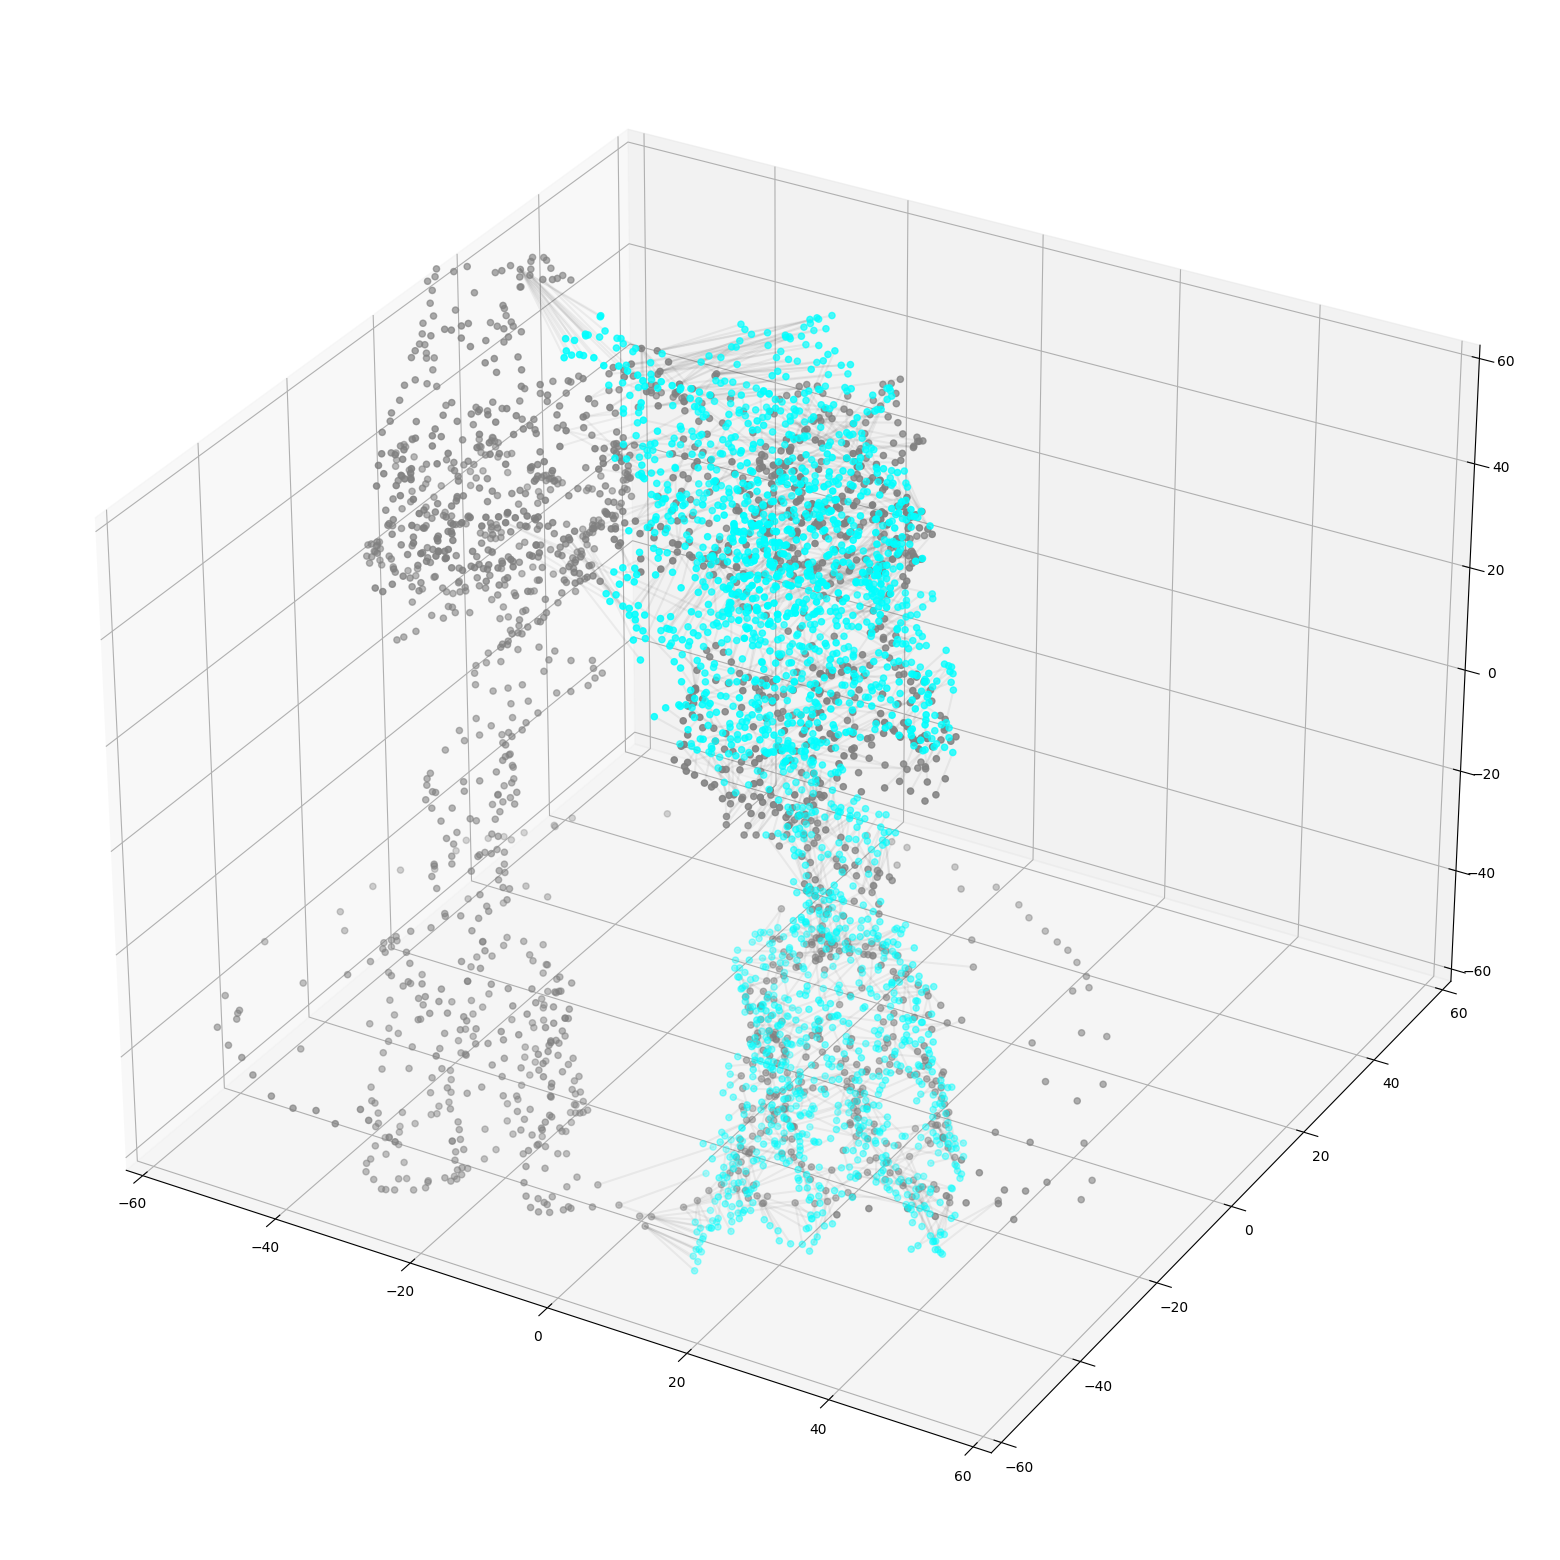

In [17]:
a1 = align_substruct(x, y, z, [('./6n52/chainA.mrc', 0.115, './6n52/chain_A.pdb')], num=n_comb, num_points=n_points)

In [86]:
# a2 = align_substruct(x, y, z, [('./6n52/chainA.mrc', 0.115, './6n52/chain_B.pdb')], num=5, num_points=n_points)
# a3 = align_substruct(x, y, z, [('./5fwp/chainC.mrc', 0.0572, './5fwp/chain_C.pdb')], num=5)
# a4 = align_substruct(x, y, z, [('./5fwp/chainD.mrc', 0.0858, './5fwp/chain_D.pdb')], num=5)

In [18]:
# alignments = choose_alignments(x, y, z, [a1, a2, a3, a4], verbose=False)
# alignments = choose_alignments(x, y, z, [a1, a2], verbose=False)

alignments = choose_alignments(x, y, z, [a1, a1], verbose=False)

In [19]:
generate_pdbs('/u01/project/chenwei-embuild/embuild_docker/maps/ref_map/emd_0346.map', alignments, f'./6n52/6n52-{n_points}-{n_comb}-')
# generate_pdbs('/u01/project/chenwei-embuild/embuild_docker/maps/reg_mcp/0346_mcp.mrc', alignments, f'./6n52/6n52-mcp-{n_points}-{n_comb}-')
#

./6n52/chain_A.pdb
./6n52/chain_A.pdb


(256, 256, 256)
(130, 130, 130)
0


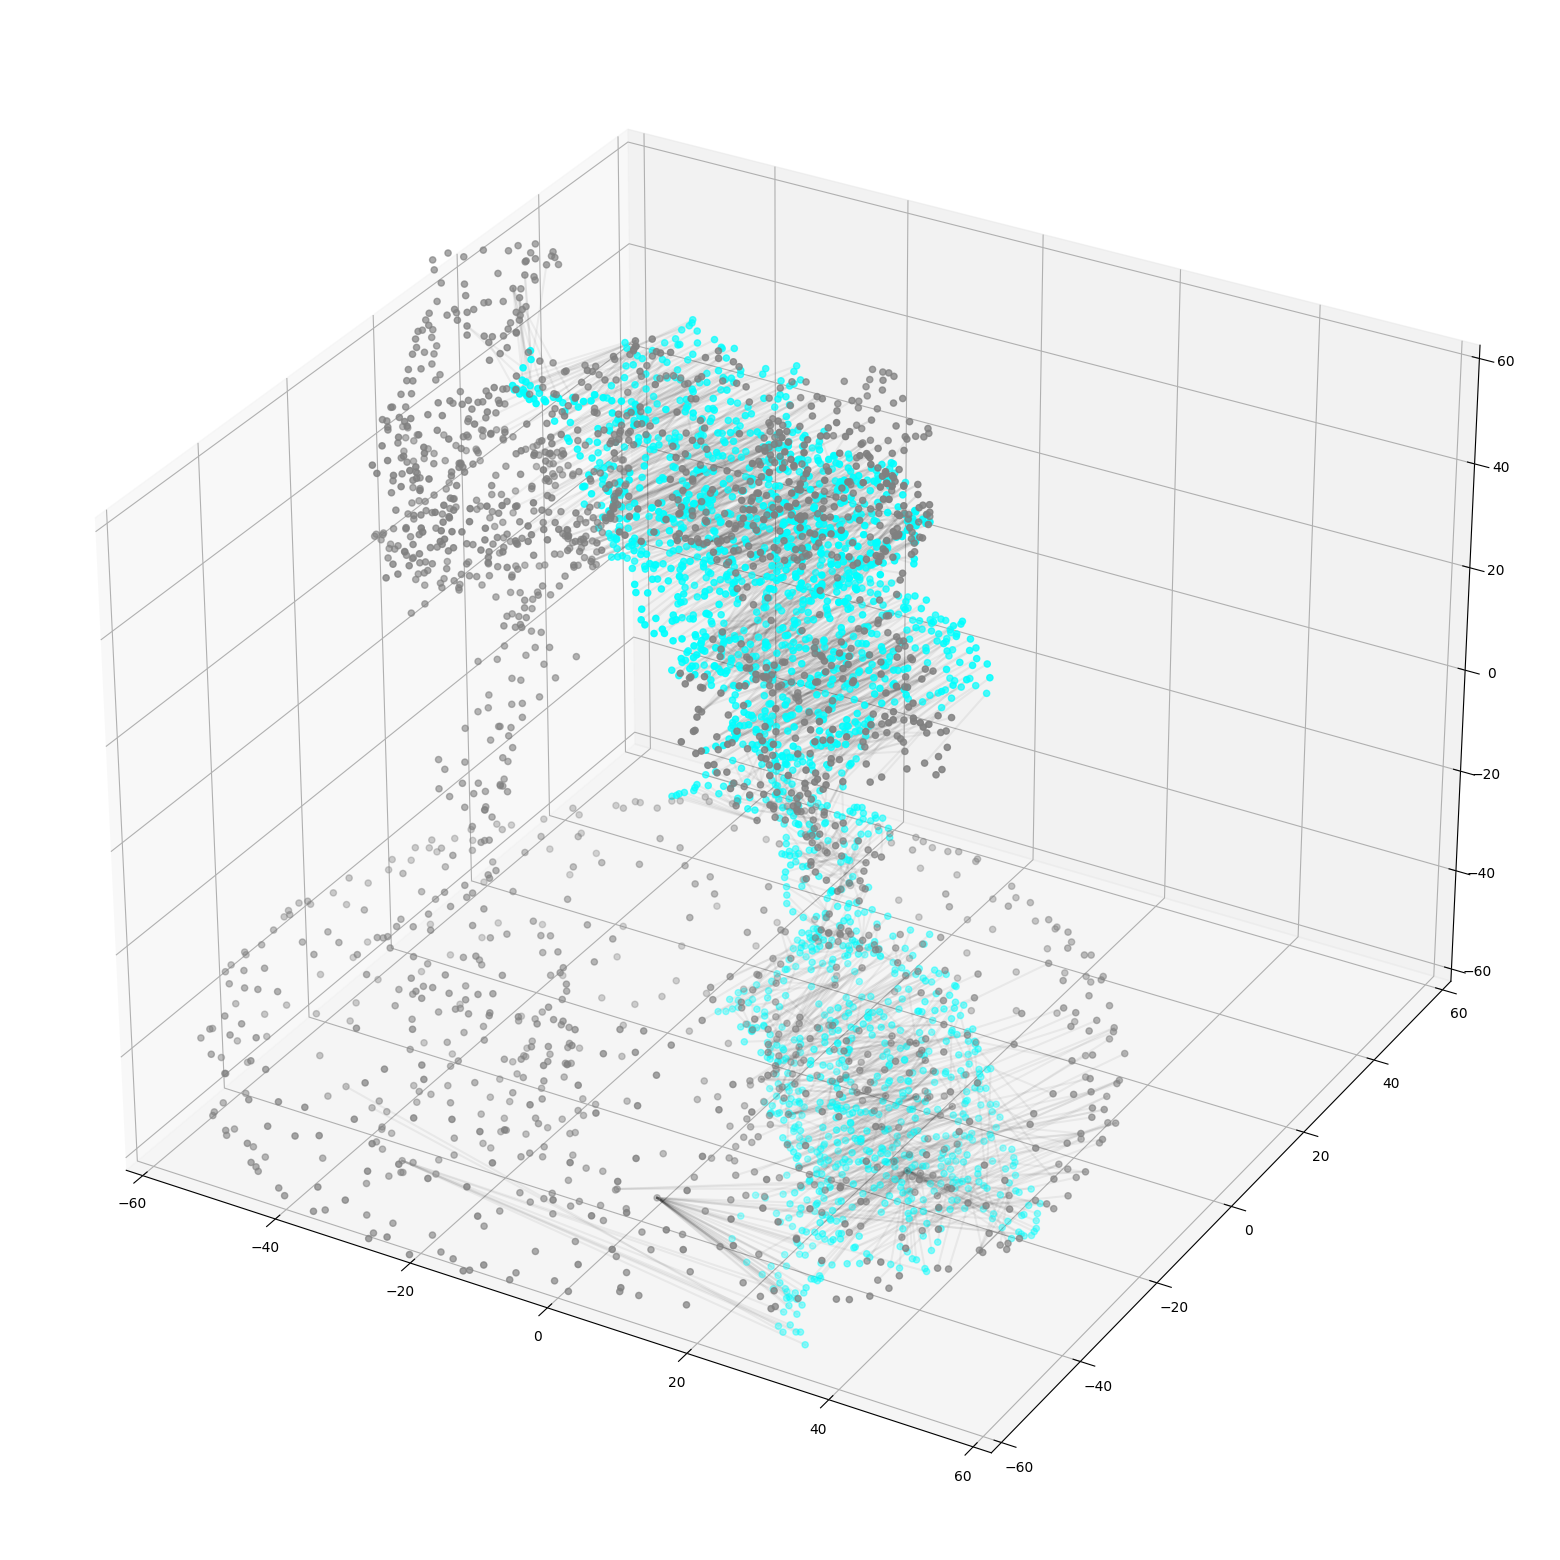

1


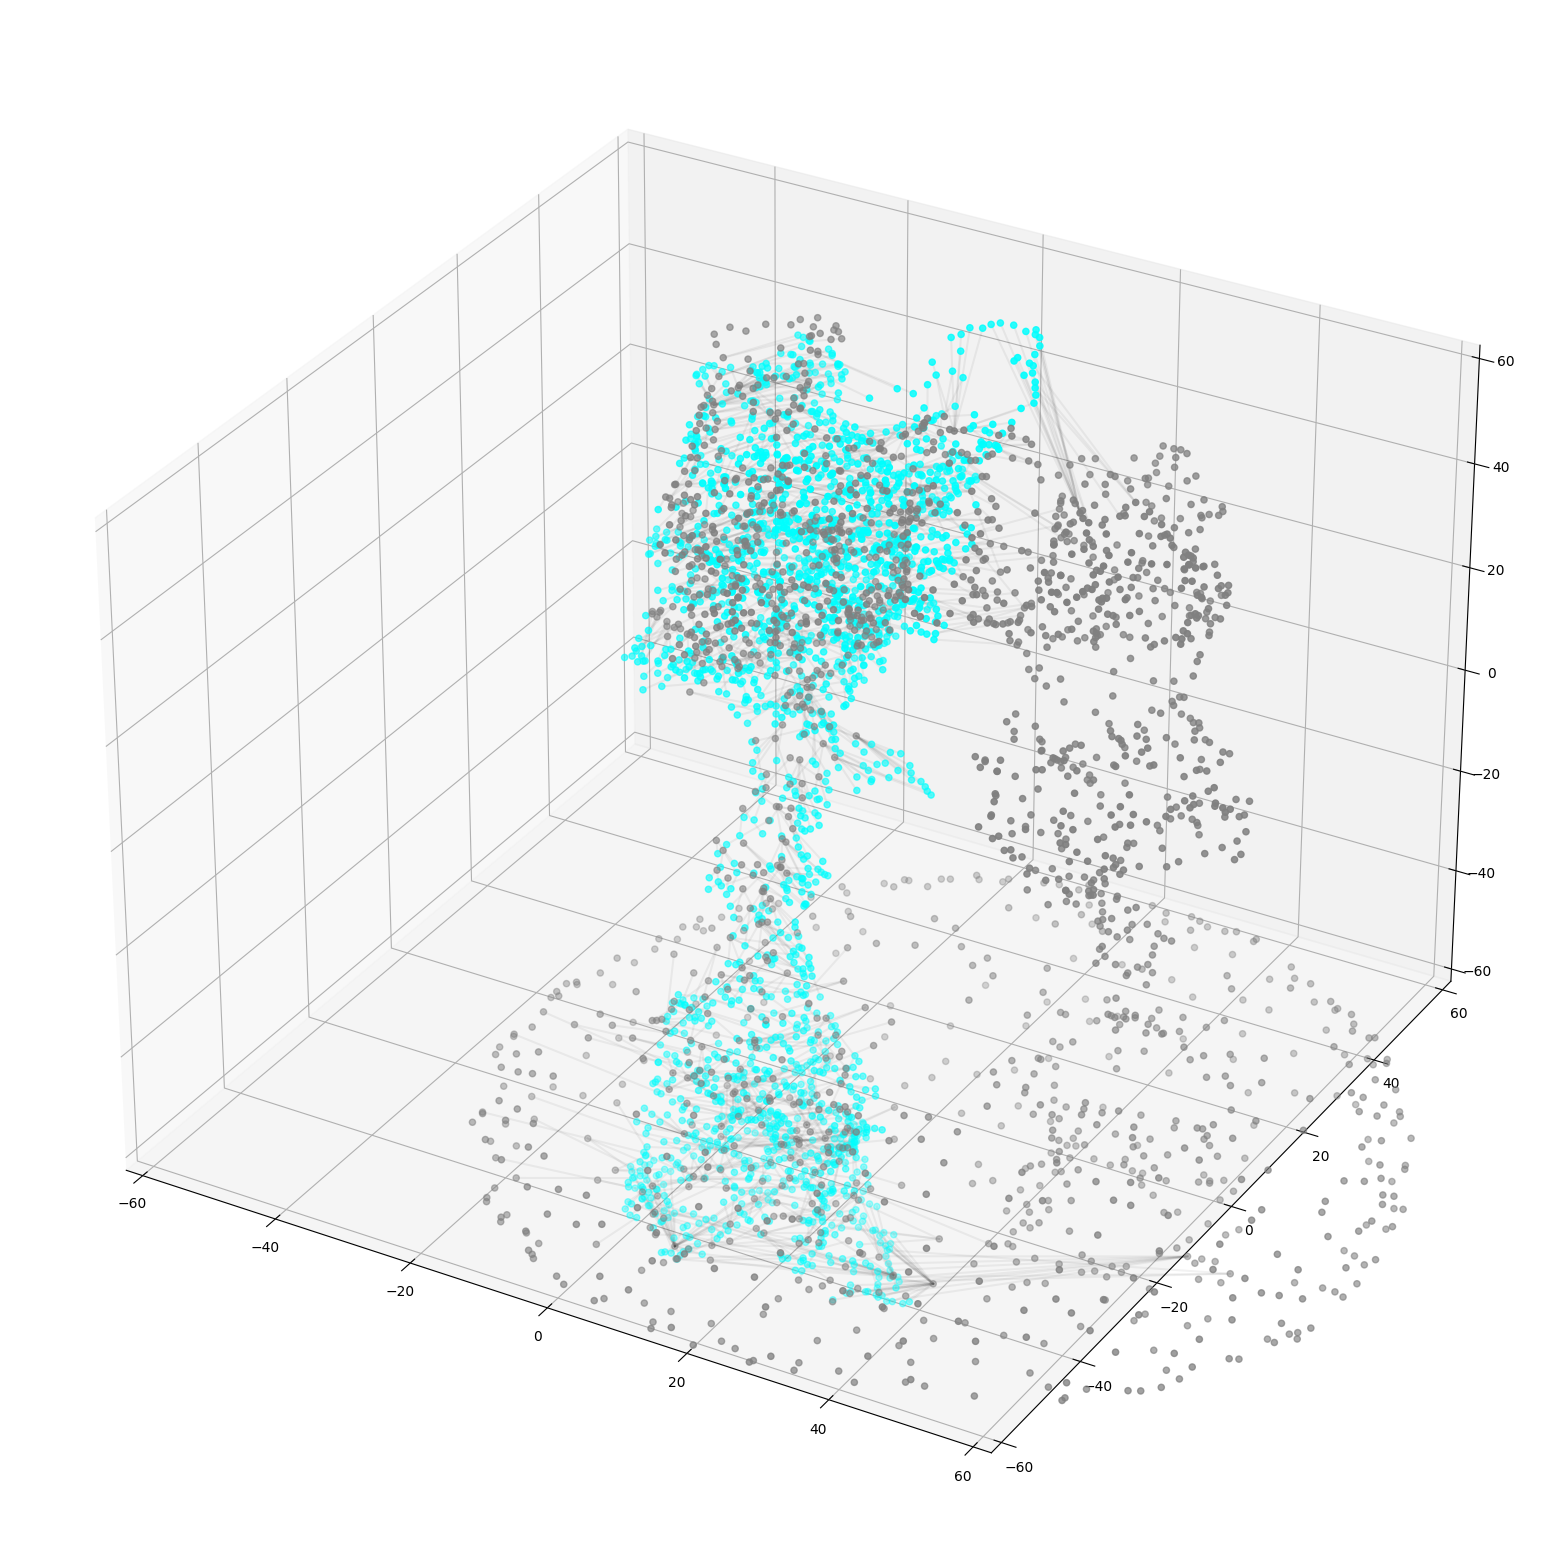

./6n52/chain_A.pdb
./6n52/chain_A.pdb


In [ ]:
n_points = 2000
n_comb = 2
x, y, z = sample('/u01/project/chenwei-embuild/embuild_docker/maps/ref_map/emd_0346.map', 0.0266, n_points,random_seed=9)
a1 = align_substruct(x, y, z, [('./6n52/chainA.mrc', 0.115, './6n52/chain_A.pdb')], num=n_comb, num_points=n_points)
alignments = choose_alignments(x, y, z, [a1, a1], verbose=False)
generate_pdbs('/u01/project/chenwei-embuild/embuild_docker/maps/ref_map/emd_0346.map', alignments, f'./6n52/6n52-{n_points}-{n_comb}-')
